# Time Series Forecasting with Prophet

In the last few years, the team at Facebook has published a new method 'Prophet' to calculate predictions on time series data. ARIMA has typically made this a challenging prospect and so a simpler method is potentially worth looking at for the simpler cases.  

Therefore, in this notebook we will take a look at Prophet and its ability to grant us insights on historic shampoo sales data over a three year period, taken from Data Market.

The data is available here: https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line.

## Step 1: Load in Data and Dependencies

In [1]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

First we need to read in our data, consisting of an excel spreadsheet with 12 header rows.  The data we need consists of monthly sales data over a three year period, with the months represented by the format (year as a four digit year representation, and a two digit representation of the month in question) with a separate column for sales figures for that month.

In [118]:
df = pd.read_excel('sales-of-shampoo-over-a-three-ye-2.xlsx', skiprows=12, usecols=1)
df.columns = ['month','sales']
df.head(5)

,month,sales
0,0001-01,266.0
1,0001-02,145.9
2,0001-03,183.1
3,0001-04,119.3
4,0001-05,180.3


## Step 2: Data Processing and Exploration

Prophet expects a DataFrame with a column of time information, and another column containing what we wish to forecast in a typical univariate time series analysis. 

Problem number 1 is that our column one is not in datetime format, so we will need to convert it.  We should probably check dtypes of our columns and for any missing data while we're at it.

In [119]:
df.dtypes

month     object
sales    float64
dtype: object

So our month column isn't in datetime format as we suspected, so we'll need to change that.  Before we do, let's check for any nulls.

In [120]:
pd.DataFrame(df.isnull().sum()).T

,month,sales
0,0,0


No nulls.  Let's do a check for any abnormal values.

In [121]:
df.describe()

,sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


Let's take a look at that max figure to check it's not abnormal in the scheme of things.

In [122]:
df.loc[df.sales == 682.00]

,month,sales
32,0003-09,682.0


In [123]:
df.loc[df.month == '0003-10']

,month,sales
33,0003-10,475.3


The variance in sales between months following the 682.00 highest sales is quite large and potentially merits further investigation.  For the purposes of this toy analysis of Prophet, we won't investigate further, but see how Prophet handles this.

First we need to deal with the date column. We will need to transform the data to a suitable format that datetime recognises.  We are unsure of the precise year that this dataset applies to, but we can simplify things by conditional logic.

We'll first split the date column on the delimiter '-' to create a year column, and then slice the string in the existing month column to remove the existing year data.

In [124]:
df['year'] = df['month'].map(lambda x: x.split('-')[0])
df['month'] = df['month'].map(lambda x: x[5:])

In [125]:
df.head()

,month,sales,year
0,01,266.0,0001
1,02,145.9,0001
2,03,183.1,0001
3,04,119.3,0001
4,05,180.3,0001


Next we will add 2000 to each value in the year column so as to create a date that Prophet and datetime will recognise.

In [126]:
df.year = df.year.astype(int)
df['year'] = df['year'].map(lambda x: x+2000)
df.head(5)

,month,sales,year
0,01,266.0,2001
1,02,145.9,2001
2,03,183.1,2001
3,04,119.3,2001
4,05,180.3,2001


Next we have to put the year and month data back together, because of strictures that Prophet requires.  We need to call our independent variable `ds` and our dependent variable `y` for Prophet to work its magic.

In [127]:
df['ds'] = df.apply(lambda row: str(row['year']) + '-' + row['month'], axis = 1)
df.head(5)

,month,sales,year,ds
0,01,266.0,2001,2001-01
1,02,145.9,2001,2001-02
2,03,183.1,2001,2001-03
3,04,119.3,2001,2001-04
4,05,180.3,2001,2001-05


Now we've got the ds column as we wish we can drop the original year and month columns thusly:

In [128]:
df.drop(['month','year'], inplace = True, axis = 1)

Next we rename the columns as they need to be for Prophet.

In [129]:
df.columns = ['y','ds']

Check is all as it should be. Yes it is.

In [130]:
df.head(5)

,y,ds
0,266.0,2001-01
1,145.9,2001-02
2,183.1,2001-03
3,119.3,2001-04
4,180.3,2001-05


Next we'll do the datetime conversion for our ds column.

In [133]:
df['ds'] = pd.DatetimeIndex(df['ds'], yearfirst = True)
df

,y,ds
0,266.0,2001-01-01
1,145.9,2001-02-01
2,183.1,2001-03-01
3,119.3,2001-04-01
4,180.3,2001-05-01
5,168.5,2001-06-01
6,231.8,2001-07-01
7,224.5,2001-08-01
8,192.8,2001-09-01
9,122.9,2001-10-01


Okay let's plot our data and look at the distribution.

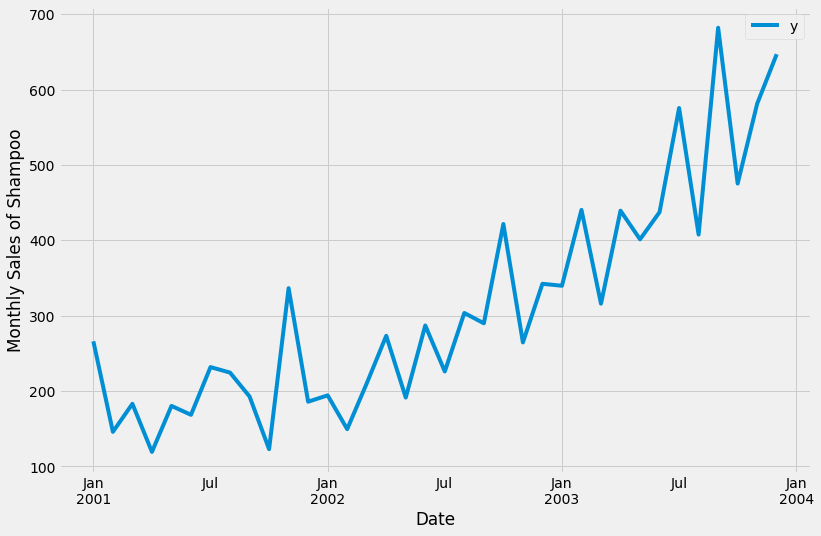

In [137]:
_ = df.set_index('ds').plot(figsize = (12,8))
_.set_xlabel('Date')
_.set_ylabel('Monthly Sales of Shampoo')
_.legend('y')
plt.show()

Clearly there are a couple of heavy spikes of sales in the summers of 2001, 2002 and 2003. There's also a clear upward trend in sales over the whole period under analysis but that is tempered by the seasonal sales.

## Step 3: Time Series Analysis and Forecasting

Prophet simplifies substantially some of the intricacies of time series forecasting.  That trade off gives benefits in terms of intuition and simplicity.  Most helpfully, Prophet can deal with missing observations or large outliers, and can roll with the punches in relation to product launches or marketing pushes.  It can also accommodate non linear growth curves (which leads to some potentially useful applications in monitoring habitats and animal colonies for example).

First of all we need to create a new object in Prophet.  In so doing, we can adjust a number of parameters, including those dealing with seasonality pertaining to holidays and daily sales cycles.

In [138]:
ts = Prophet(interval_width = 0.68)

In [140]:
ts.fit(df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now that we have our time series model, to obtain forecasts, we need to create a new dataframe with a ds column for future dates.  Happily, Prophet includes a method that enables us to make such a dataframe.  We can choose to include or exclude historic data in our predictions. In this case, we'll predict on future dates, rather than testing our model against ground truth.

In [155]:
preds = ts.make_future_dataframe(periods = 36, freq= 'MS', include_history=True) #MS is the start of the month
preds.tail()

,ds
67,2006-08-01
68,2006-09-01
69,2006-10-01
70,2006-11-01
71,2006-12-01


As with most instances of machine learning, we take our test set (our future dates dataframe) and apply our model trained on the historic data to it.

In [156]:
forecast = ts.predict(preds)
forecast[['ds','yhat','yhat_lower','yhat_upper']].head(5)

,ds,yhat,yhat_lower,yhat_upper
0,2001-01-01,130.724029,59.593912,198.836043
1,2001-02-01,106.474441,36.654230,176.833534
2,2001-03-01,100.748858,31.787873,170.272045
3,2001-04-01,138.141359,65.524477,204.269888
4,2001-05-01,120.580444,53.948864,189.749455


What we obtain in return from the model is a DataFrame, and we go through each returned feature in the DataFrame below:

In [157]:
pd.DataFrame([['ds','our datetime field for future values'],['yhat','our estimate of the true value of y in the future'], ['yhat_lower','estimated lower bound of our estimate of y'],['yhat_upper', 'estimated upper bound of our estimate of y']], columns = ['feature','details'])

,feature,details
0,ds,our datetime field for future values
1,yhat,our estimate of the true value of y in the future
2,yhat_lower,estimated lower bound of our estimate of y
3,yhat_upper,estimated upper bound of our estimate of y


Prophet generates its forecasts by sampling our existing data many many times, via markov chain monte carlo methods. We won't get the same results each time as (as is the same with other markov chain monte carlo packages) we have created a stochastic object and as such is subject to some randomness.

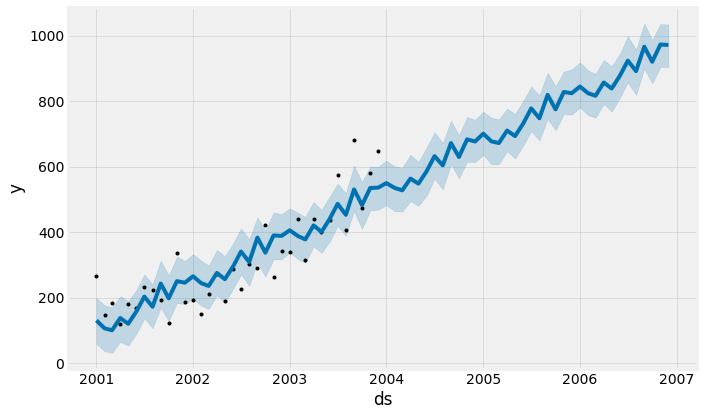

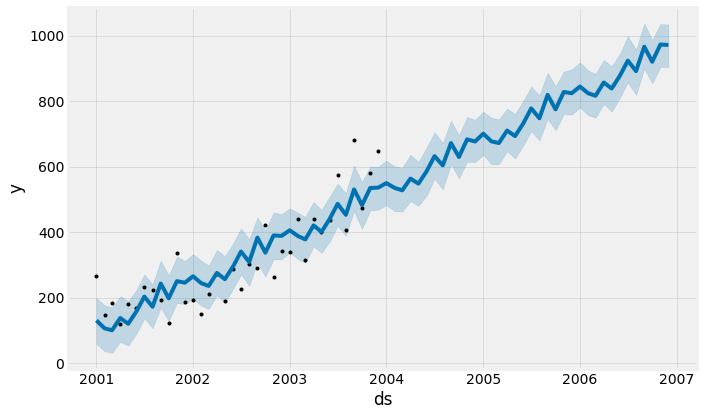

In [158]:
ts.plot(forecast, uncertainty = True)

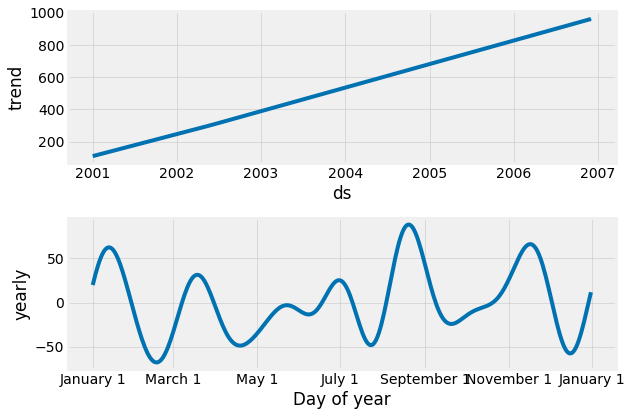

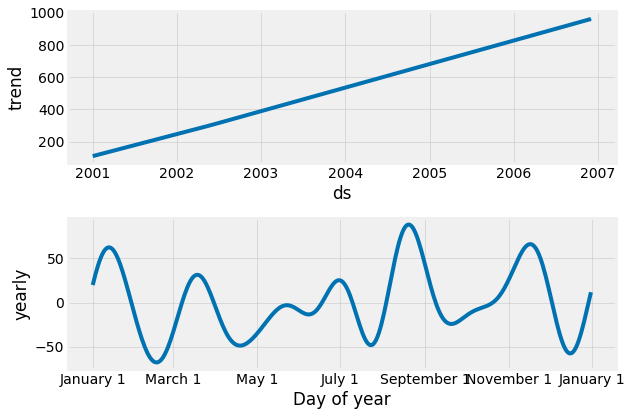

In [159]:
ts.plot_components(forecast)

Seemingly, sales seem to peak in around September each year with another spike in November.  Sales appear to nosedive in March in particular.  

Certainly, Prophet has concluded that sales are on an upward straight line trend. It does not detect any inflection point in sales.  If anything, seasonality seems to have had the most effect on varying sales.

It's worth noting that we set our confidence interval to 68%.  You can see that this confidence interval may not be quite right since Prophet has missed a few ourliers in the datasert to which it has been exposed via setting its confidence intervals and fitting the line through the data.  This has led to quite a narrow confidence interval and set of predictions, and some consequent error.  We can, of course, rerun with more strict confidence intervals which should change the predictions slightly.  We will do this now, yet we should bear in mind that if we want a useful predictive model, we would ordinarily wish to strike a balance in the bias and variance trade-off. 

## Step 4: Tune Model

In [160]:
ts_2 = Prophet(interval_width = 0.95) #increase our confidence interval

In [161]:
ts_2.fit(df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [162]:
rev_forecast = ts_2.predict(preds)
rev_forecast[['ds','yhat','yhat_lower','yhat_upper']].head(5)

,ds,yhat,yhat_lower,yhat_upper
0,2001-01-01,130.724029,-4.685143,262.821859
1,2001-02-01,106.474441,-24.384715,248.483405
2,2001-03-01,100.748858,-37.789287,238.164569
3,2001-04-01,138.141359,-4.114964,259.624390
4,2001-05-01,120.580444,-30.090148,257.089140


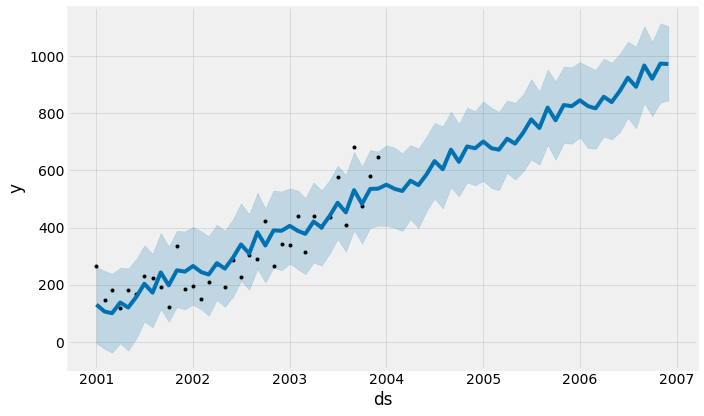

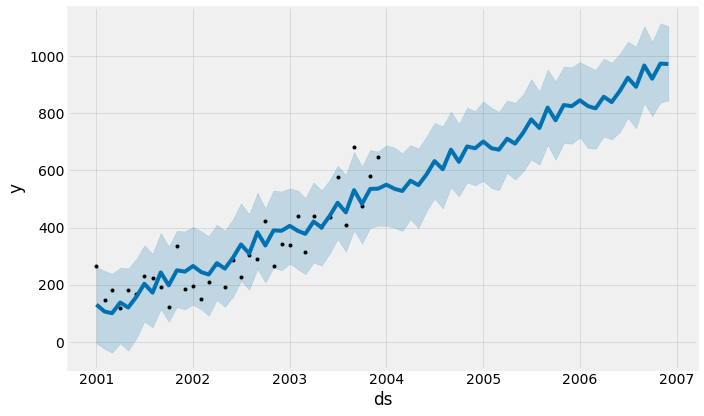

In [164]:
ts_2.plot(rev_forecast, uncertainty = True)

So we can see here that our increased confidence interval is reflected in the wider margin of confidence around the blue line of our values for y_hat, representing the upper and lower bounds of our prediction.  The overall shape of our forecast remains the same, however.

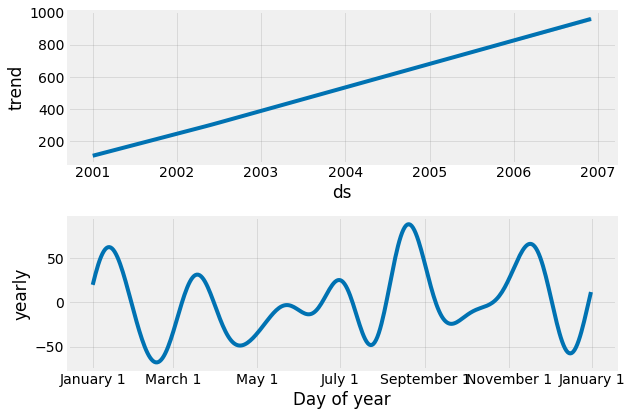

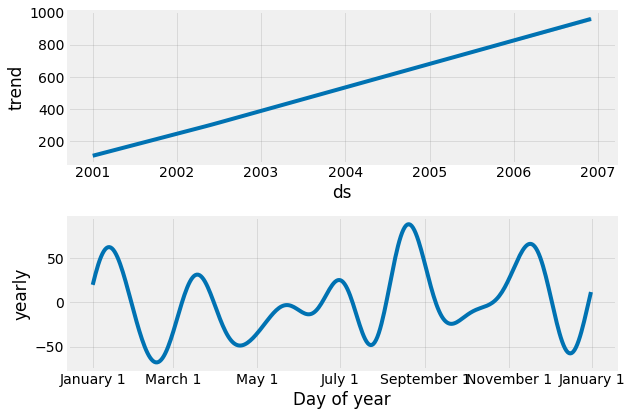

In [165]:
ts_2.plot_components(rev_forecast)

And again, the components tell us much the same story - the overall upward and continuous and linear trend over time, and the seasonal affected trends over the course of a year.